<a href="https://colab.research.google.com/github/JackLafond/FlowerCNN/blob/main/FlowerCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir images
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
!tar zxvf flower_photos.tgz -C /content/images/

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 73, 73, 32)        0         
                                                                 
 conv2d_1 (Conv2D)     

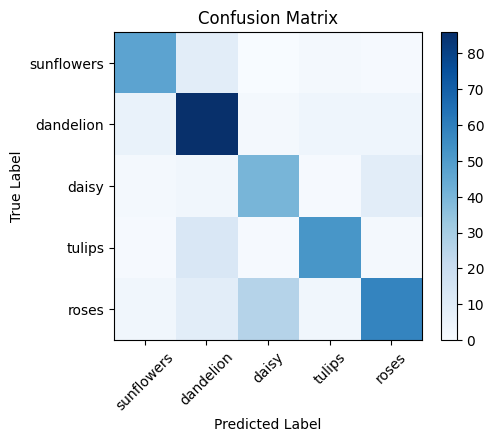

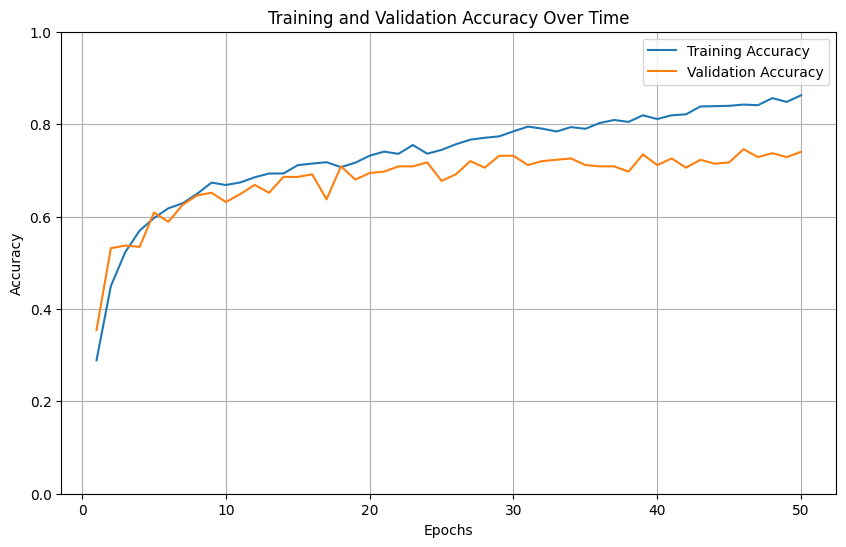

              precision    recall  f1-score   support

  sunflowers       0.80      0.80      0.80        59
   dandelion       0.72      0.84      0.77       102
       daisy       0.58      0.73      0.65        55
      tulips       0.84      0.75      0.79        69
       roses       0.78      0.59      0.67        99

    accuracy                           0.74       384
   macro avg       0.74      0.74      0.74       384
weighted avg       0.75      0.74      0.74       384



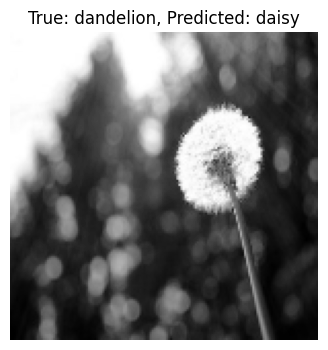

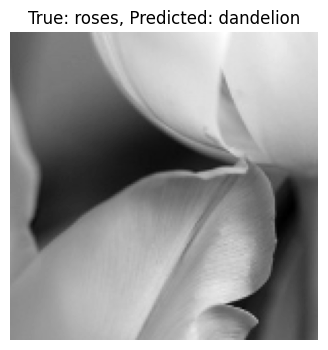

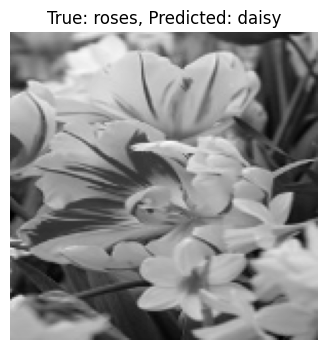

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

config = {
    'batch_size': 128,
    'image_size': (150,150),
    'epochs': 50,
    'optimizer': keras.optimizers.Adam(lr=.001)
}

def read_data():

    train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
        "./images/flower_photos",
        validation_split=0.2,
        subset="both",
        seed=42,
        image_size=config['image_size'],
        batch_size=config['batch_size'],
        labels='inferred',
        label_mode = 'int'
    )

    val_batches = tf.data.experimental.cardinality(val_ds)
    test_ds = val_ds.take(val_batches // 2)
    val_ds = val_ds.skip(val_batches // 2)
    return train_ds, val_ds, test_ds

def data_processing(ds):

    data_augmentation = keras.Sequential(
        [layers.RandomFlip("horizontal"), layers.RandomRotation(factor = (-.3, .3))]
    )

    ds = ds.map(
        lambda img, label: (data_augmentation(img), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

def build_model(input_shape, num_classes):

    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(32, (5, 5), activation='relu', input_shape=(150, 150, 3))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Conv2D(96, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Conv2D(96, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)

    outputs = layers.Dense(num_classes, activation="softmax", kernel_initializer='he_normal')(x)
    model = keras.Model(inputs, outputs)
    print(model.summary())
    return model

if __name__ == '__main__':

    # Load and Process the dataset
    train_ds, val_ds, test_ds = read_data()
    train_ds = data_processing(train_ds)

    # Build up the CNN model
    model = build_model(config['image_size']+(3,), 5)

    # Compile the model with optimizer and loss function
    model.compile(
        optimizer=config['optimizer'],
        loss='SparseCategoricalCrossentropy',
        metrics=["accuracy"],
    )

    # Fit the model with training dataset
    history = model.fit(
        train_ds,
        epochs=config['epochs'],
        validation_data=val_ds
    )

    print(history.history)
    test_loss, test_acc = model.evaluate(test_ds, verbose=2)
    print("\nTest Accuracy: ", test_acc)
    test_images = np.concatenate([x for x, y in test_ds], axis=0)
    test_labels = np.concatenate([y for x, y in test_ds], axis=0)
    test_prediction = np.argmax(model.predict(test_images),1)

    # Define Class Names:
    class_names = ["sunflowers", "dandelion", "daisy", "tulips", "roses"]

    # Save Model
    model.save("best_trained_model_CNN.keras")

    # Visualize the confusion matrix by matplotlib and sklearn based on test_prediction and test_labels
    confusion_matrix = confusion_matrix(test_labels, test_prediction)
    plt.figure(figsize=(5, 4))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot for accuracy and val accuracy
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Create a plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 51), training_accuracy, label='Training Accuracy')
    plt.plot(range(1, 51), validation_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy Over Time')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

    # Report the precision and recall
    classification_rep = classification_report(test_labels, test_prediction, target_names=class_names)
    print(classification_rep)

    misclassified_indices = np.where(test_labels != test_prediction)[0]
    num_misclassified_to_visualize = 3
    for i in range(num_misclassified_to_visualize):
        index = misclassified_indices[i]
        misclassified_image = test_images[index]
        gray_image = np.dot(misclassified_image[...,:3], [0.299, 0.587, 0.144])
        true_label = test_labels[index]
        predicted_label = test_prediction[index]

        # Display the misclassified image
        plt.figure(figsize=(4, 4))
        plt.imshow(gray_image, cmap=plt.get_cmap('gray'))
        plt.title(f'True: {class_names[true_label]}, Predicted: {class_names[predicted_label]}')
        plt.axis('off')
        plt.show()